In [18]:
%load_ext autoreload
import os
import sys

os.environ['TRANSFORMERS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ['HF_DATASETS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ["WANDB_PROJECT"] = "ft-llama-on-conversations"  # name your W&B project
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ["WANDB_PROJECT"] = "ft-llama-on-pr-summary-gen"  # name your W&B project
sys.path.append('./src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%autoreload
import baselines
import utils
import datadreamer_generation
import prompts
import random
from llm_based_evaluation import *
import datasets
from transformers import AutoTokenizer

In [20]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/'

In [4]:
dataset = datasets.load_dataset("miladalsh/sci-news")
training_ds = dataset['train'].filter(lambda row: row['source'] == 'SciNews')

README.md:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

In [5]:
training_ds  = training_ds.map(lambda row: {'parsed-pr-article': row['pr-summary-and-article']})

In [50]:
len(training_ds)

33497

In [ ]:
resulted_ds = evaluate_communicative_quality(training_ds, prompts.pr_scientific_context_eval_prompt)
resulted_df.save_to_disk(output_dir + '/training_ds_with_scientific_scores')

In [38]:
resulted_ds = evaluate_communicative_quality(training_ds, prompts.pr_societal_context_eval_prompt)
resulted_ds.save_to_disk(output_dir + '/training_ds_with_scoietal_scores')

Saving the dataset (0/5 shards):   0%|          | 0/33497 [00:00<?, ? examples/s]

In [ ]:
resulted_ds = evaluate_communicative_quality(training_ds, prompts.pr_clarity_eval_prompt)
resulted_ds.save_to_disk(output_dir + '/training_ds_with_clarity_scores')

  0%|                                                                           | 1/33497 [00:02<25:32:19,  2.74s/it]

In [53]:
resulted_ds

Dataset({
    features: ['id', 'pr-title', 'pr-article', 'pr-summary', 'sc-title', 'sc-article', 'sc-abstract', 'sc-section_names', 'sc-sections', 'sc-authors', 'source', 'Topic', 'Citation', 'Paper_URL', 'News_URL', 'pr-summary-and-article', 'parsed-pr-article', 'clarity_eval_prompt_scoring_parsed'],
    num_rows: 33497
})

In [4]:
training_ds_w_scientific_scores = datasets.load_from_disk(output_dir + 'training_ds_with_scientific_scores')
training_ds_w_societal_scores = datasets.load_from_disk(output_dir + 'training_ds_with_scoietal_scores')
training_ds_w_clarity_scores = datasets.load_from_disk(output_dir + 'training_ds_with_clarity_scores')

In [5]:
training_ds_w_quality_scores = training_ds_w_societal_scores.add_column('scientific_eval_prompt_scoring_parsed', training_ds_w_scientific_scores['scientific_eval_prompt_scoring_parsed'])
training_ds_w_quality_scores = training_ds_w_quality_scores.add_column('clarity_eval_prompt_scoring_parsed', training_ds_w_clarity_scores['clarity_eval_prompt_scoring_parsed'])

In [6]:
sci_scores = [x['score'] for x in training_ds_w_quality_scores['scientific_eval_prompt_scoring_parsed']]
print('Scientific Scores: ', 'Score 1:', sci_scores.count('1'), 'Score 2:', sci_scores.count('2'), 'Score 3:', sci_scores.count('3'))

soc_scores = [x['score'] for x in training_ds_w_quality_scores['societal_eval_prompt_scoring_parsed']]
print('Scientific Scores: ', 'Score 1:', soc_scores.count(1), 'Score 2:', soc_scores.count(2), 'Score 3:', soc_scores.count(3))

soc_scores = [x['score'] for x in training_ds_w_quality_scores['clarity_eval_prompt_scoring_parsed']]
print('Clarity Scores: ', 'Score 1:', soc_scores.count(1), 'Score 2:', soc_scores.count(2), 'Score 3:', soc_scores.count(3), 'Score 4:', soc_scores.count(4), 'Score 5:', soc_scores.count(5))

Scientific Scores:  Score 1: 3789 Score 2: 9265 Score 3: 20443
Scientific Scores:  Score 1: 3154 Score 2: 19779 Score 3: 10564
Clarity Scores:  Score 1: 180 Score 2: 819 Score 3: 1923 Score 4: 14353 Score 5: 16222


In [7]:
training_ds_w_quality_scores = training_ds_w_quality_scores.map(lambda row: {'avg_quality_score': (int(row['scientific_eval_prompt_scoring_parsed']['score']) + int(row['societal_eval_prompt_scoring_parsed']['score']))/2})

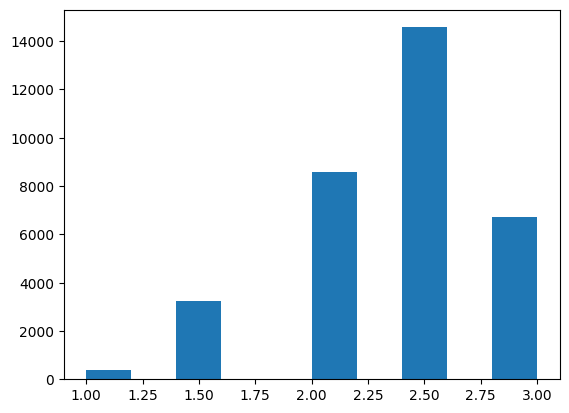

In [8]:
import matplotlib.pyplot as plt

plt.hist([x['avg_quality_score'] for x in training_ds_w_quality_scores])
plt.show()

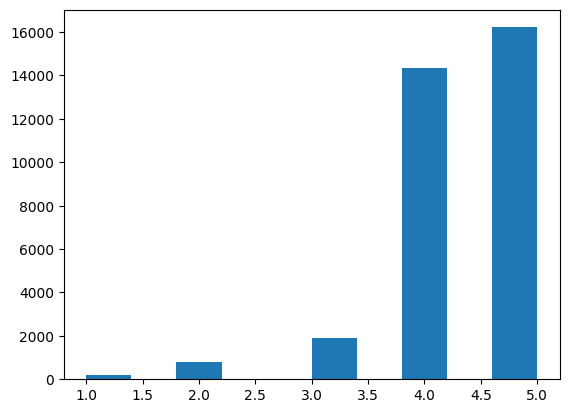

In [9]:
import matplotlib.pyplot as plt

plt.hist([x['clarity_eval_prompt_scoring_parsed']['score'] for x in training_ds_w_quality_scores])
plt.show()

In [10]:
# We create training dataset from high quality PRs (a clarity score of equal or more than 4 and an average score of societal and scientific bigger than 2
training_ds_filtered_by_quality = training_ds_w_quality_scores.filter(lambda row: row['clarity_eval_prompt_scoring_parsed']['score'] >= 4 and row['avg_quality_score'] > 2)

In [ ]:
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

sc_intro = [utils.build_model_context(row, llama_tokenizer, max_token_number=3000) for i, row in training_ds_filtered_by_quality.to_pandas().iterrows()]
training_ds_filtered_by_quality = training_ds_filtered_by_quality.add_column('sc-intro', sc_intro)
training_ds_filtered_by_quality = training_ds_filtered_by_quality.filter(lambda row: row['sc-intro'] != '')

In [17]:
training_ds_filtered_by_quality

Dataset({
    features: ['id', 'pr-title', 'pr-article', 'pr-summary', 'sc-title', 'sc-article', 'sc-abstract', 'sc-section_names', 'sc-sections', 'sc-authors', 'source', 'Topic', 'Citation', 'Paper_URL', 'News_URL', 'pr-summary-and-article', 'parsed-pr-article', 'societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed', 'avg_quality_score', 'sc-intro'],
    num_rows: 19812
})

In [16]:
training_ds_filtered_by_quality.save_to_disk(output_dir + "/high_quality_news_dataset")

Saving the dataset (0/4 shards):   0%|          | 0/19812 [00:00<?, ? examples/s]